In [1]:
import os
import pickle
import numpy as np
import scipy.interpolate as spi
import matplotlib.pyplot as plt
%matplotlib inline

import flayer
import particle_evolution
import feo_thermodynamics as feot
import multiprocessing
import bulk_case_runner
import earth_model

prem = earth_model.Prem()


In [2]:
files = ['just_t/nuc_b/slurry-T-A.pickle', 'just_t/nuc_c/slurry-T-A.pickle',
         'just_t/nuc_d/slurry-T-A.pickle', 'just_t/nuc_e/slurry-T-A.pickle',
         'just_t/nuc_f/slurry-T-A.pickle', 'just_t/nuc_g/slurry-T-A.pickle']

In [3]:
rs_fitted = []
ts_out = []
ts_fitted = []
i0s = []
nuc_max=[]

for file in files:
    data = bulk_case_runner.load_case_data(file)
    #bulk_case_runner.plot_case_csd_nuc(logscale=True, nonuc=True, **data)
    #bulk_case_runner.plot_case_solid_frac(**data)
    
    # This is where we set all the F-layer parameters. Quite slow (due to liquidus calc I think)

    # F-layer setup
    radius_inner_core = data["r_icb"]
    f_layer_thickness = data["f_layer_thickness"]
    radius_top_flayer = radius_inner_core + f_layer_thickness # 200 km thick.
    radius_cmb = data["r_cmb"] # We only need this for setup.
    gamma = data["gruneisen_parameter"] 

    # Generate the functions for temperautre,
    # composition, pressure and gravity
    knott_radii = np.linspace(radius_inner_core, radius_top_flayer, data["number_of_knots"])
    tfunc, atfunc, ftfunc, tfunc_creator, xfunc, pfunc, \
        gfunc = flayer.setup_flayer_functions(radius_inner_core, radius_cmb, f_layer_thickness, 
                                                    gamma, data["delta_t_icb"], data["xfe_outer_core"],
                                          data["xfe_icb"], knott_radii)

    print("Temperature at CMB is", tfunc(radius_cmb), "K")

    tfunc = tfunc_creator(data["t_params"])

    print("Temperature at top of F-layer is", tfunc(radius_top_flayer), "K")
    print("Temperature at ICB is", tfunc(radius_inner_core), "K")

    # Interpolate onto radius for plotting
    rs = np.linspace(radius_inner_core, radius_inner_core+250.0E3)
    ts = tfunc(rs)
    ats = atfunc(rs)
    ps = pfunc(rs)
    xs = xfunc(rs)
    # Find the P-X dependent liquidus (storing the temperature at each point)
    tl = feot.find_liquidus(xs, ps)
    
    rs_fitted.append(rs[rs<=radius_top_flayer]/1000.0)
    ts_fitted.append(ts[rs<=radius_top_flayer])
    ts_out.append(data["out_t_points"])
    i0s.append(data["i0"])
    nuc_max.append(np.nanmax(data["nucleation_rates"]))
    
    


Temperature at CMB is 4225.944695087244 K
Temperature at top of F-layer is 5676.644650924955 K
Temperature at ICB is 5774.167092699356 K
Temperature at CMB is 4225.944695087244 K
Temperature at top of F-layer is 5676.644650924955 K
Temperature at ICB is 5785.156648863579 K
Temperature at CMB is 4225.944695087244 K
Temperature at top of F-layer is 5676.644650924955 K
Temperature at ICB is 5688.161923703304 K
Temperature at CMB is 4225.944695087244 K
Temperature at top of F-layer is 5676.644650924956 K
Temperature at ICB is 5725.432601329446 K
Temperature at CMB is 4225.944695087244 K
Temperature at top of F-layer is 5676.6446509249545 K
Temperature at ICB is 5755.585212920864 K
Temperature at CMB is 4225.944695087244 K
Temperature at top of F-layer is 5676.644650924955 K
Temperature at ICB is 5767.1703840560585 K


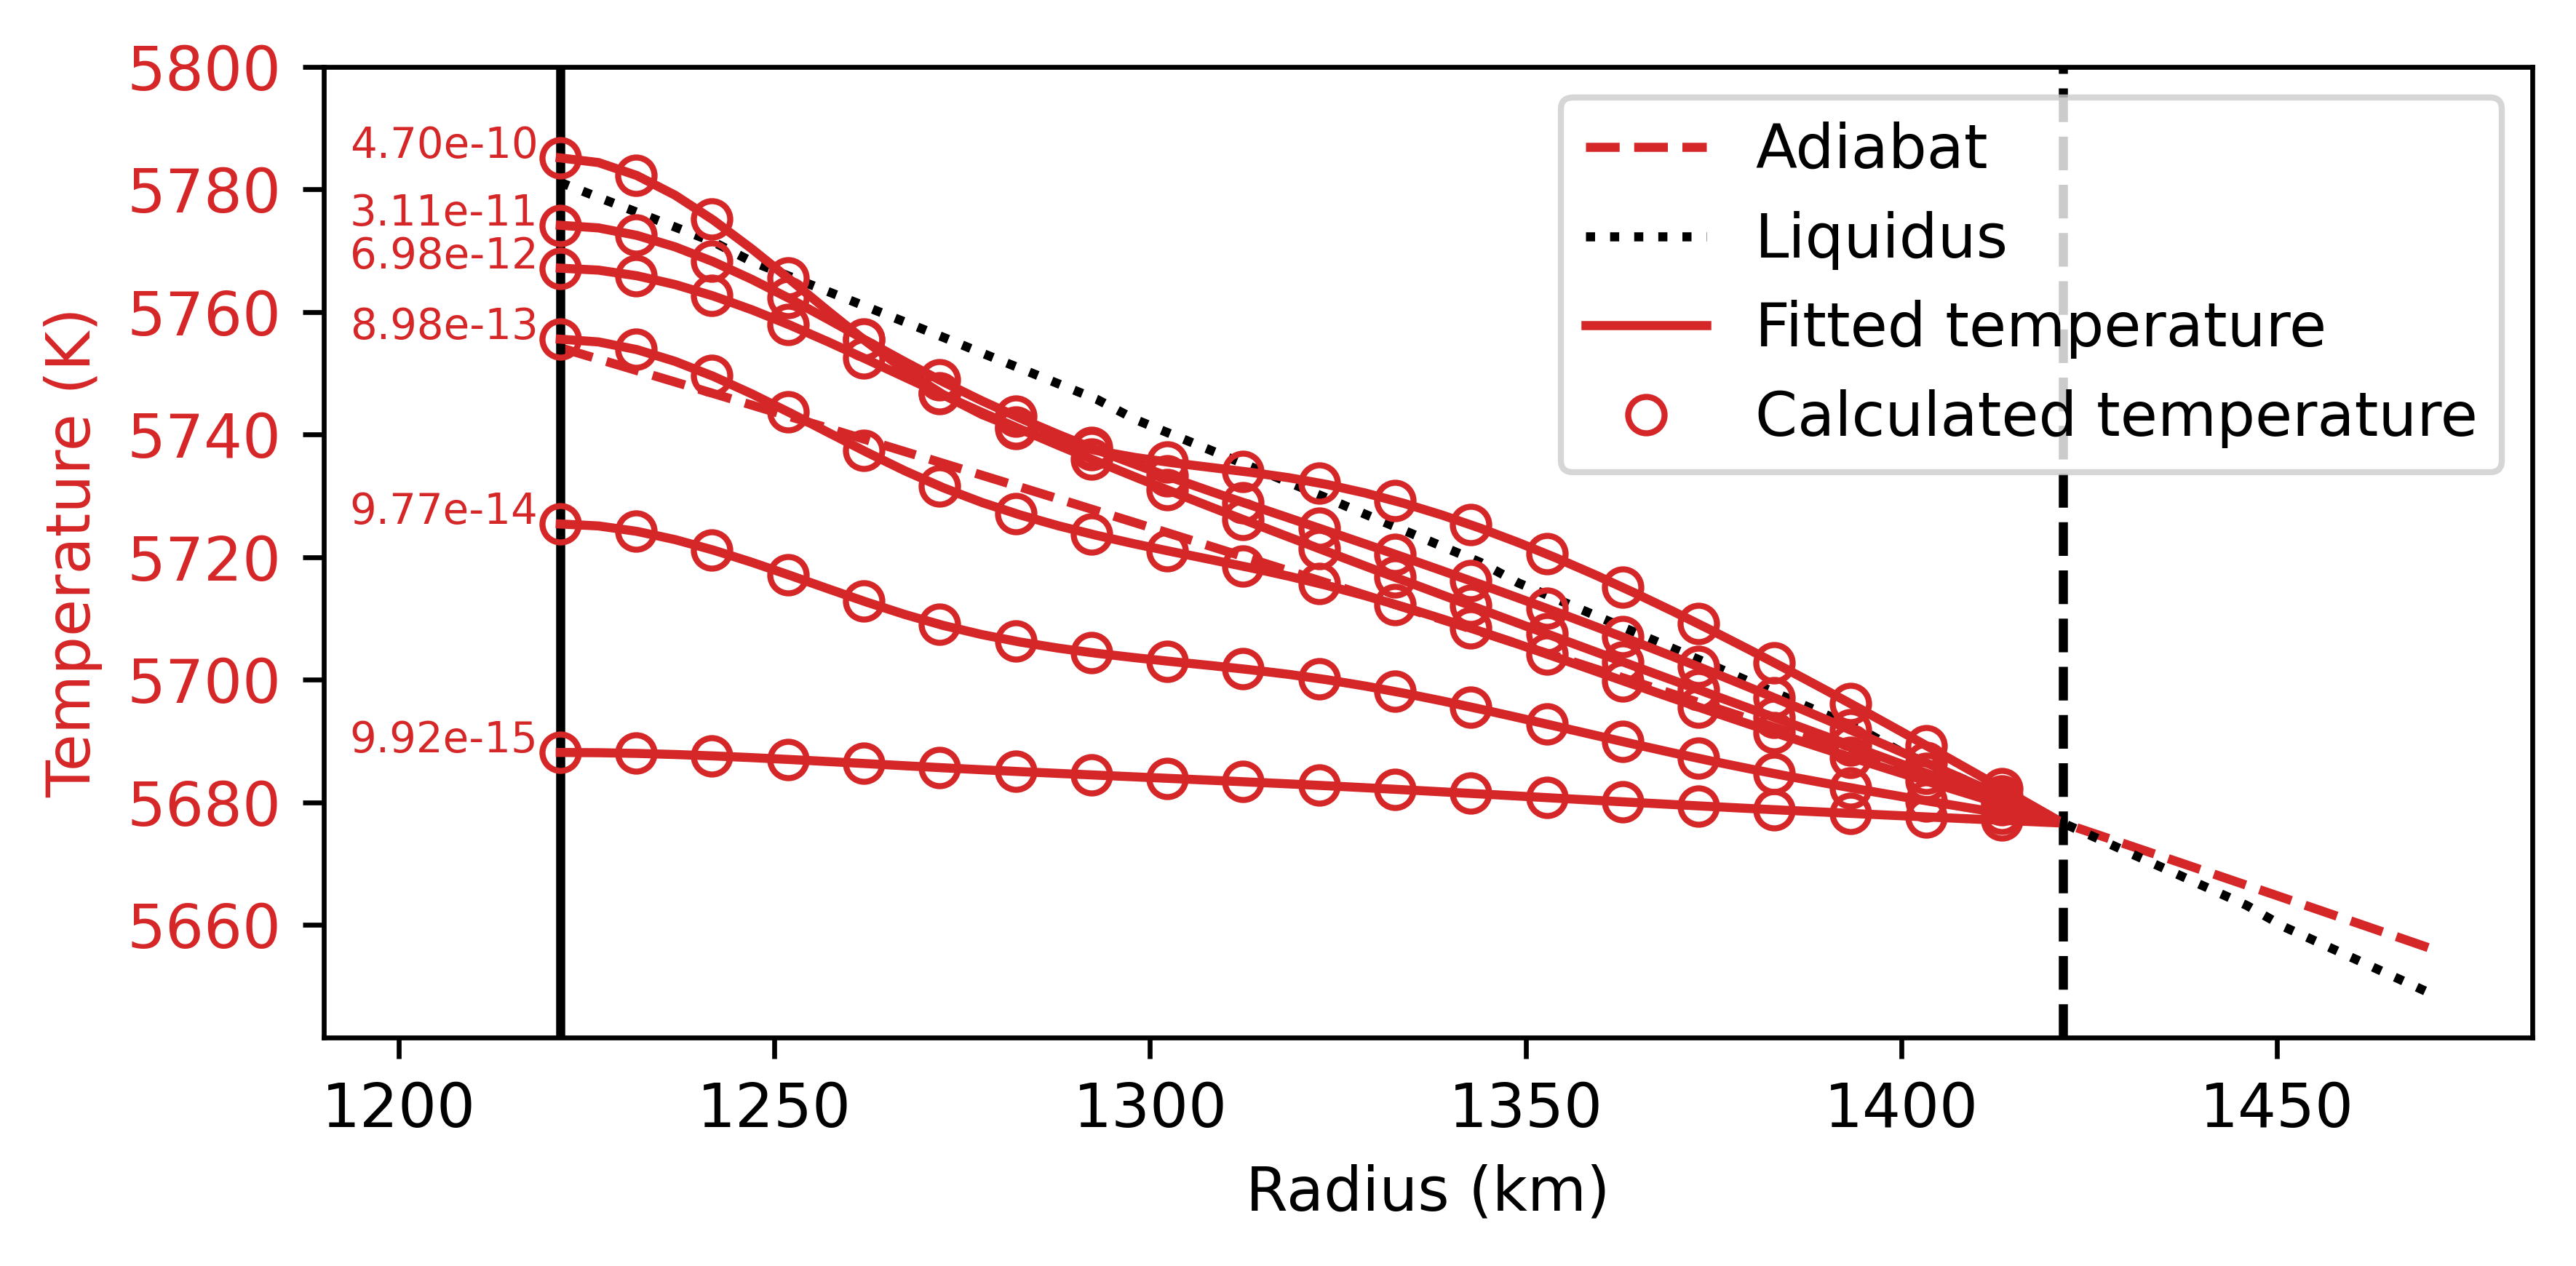

In [4]:
# Plot the F-layer setup alongside the liquidus
fig, ax1 = plt.subplots(figsize=(6,3), tight_layout=True, dpi=600)

color = 'tab:red'
ax1.set_xlabel('Radius (km)')
ax1.set_ylabel('Temperature (K)', color=color)
ax1.plot(rs/1000.0, ats, color=color, ls='--', label='Adiabat')
ax1.plot(rs/1000.0, tl, color='k', ls=':', label='Liquidus')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim(left=1190)
ax1.axvline(x=1221.5, color='k')
ax1.axvline(x=1421.5, color='k', ls='--')
ax1.set_ylim(top=5800)

lab=True
for r_fit, t_fit, t_out, i0 in zip(rs_fitted, ts_fitted, ts_out, nuc_max):
        
    if lab:
        ax1.plot(r_fit, t_fit, color=color, ls='-', label='Fitted temperature')
        ax1.plot(data["analysis_radii"][::5]/1000.0, t_out[::5], 'o', color=color, fillstyle='none', label='Calculated temperature')
        lab=False
    else:
        ax1.plot(r_fit, t_fit, color=color, ls='-')
        ax1.plot(data["analysis_radii"][::5]/1000.0, t_out[::5], 'o', color=color, fillstyle='none')
    ax1.text(r_fit[0]-28, t_fit[0], f"{i0:.2e}", color=color, size='x-small')

ax1.legend()

fig.tight_layout()  
plt.show()

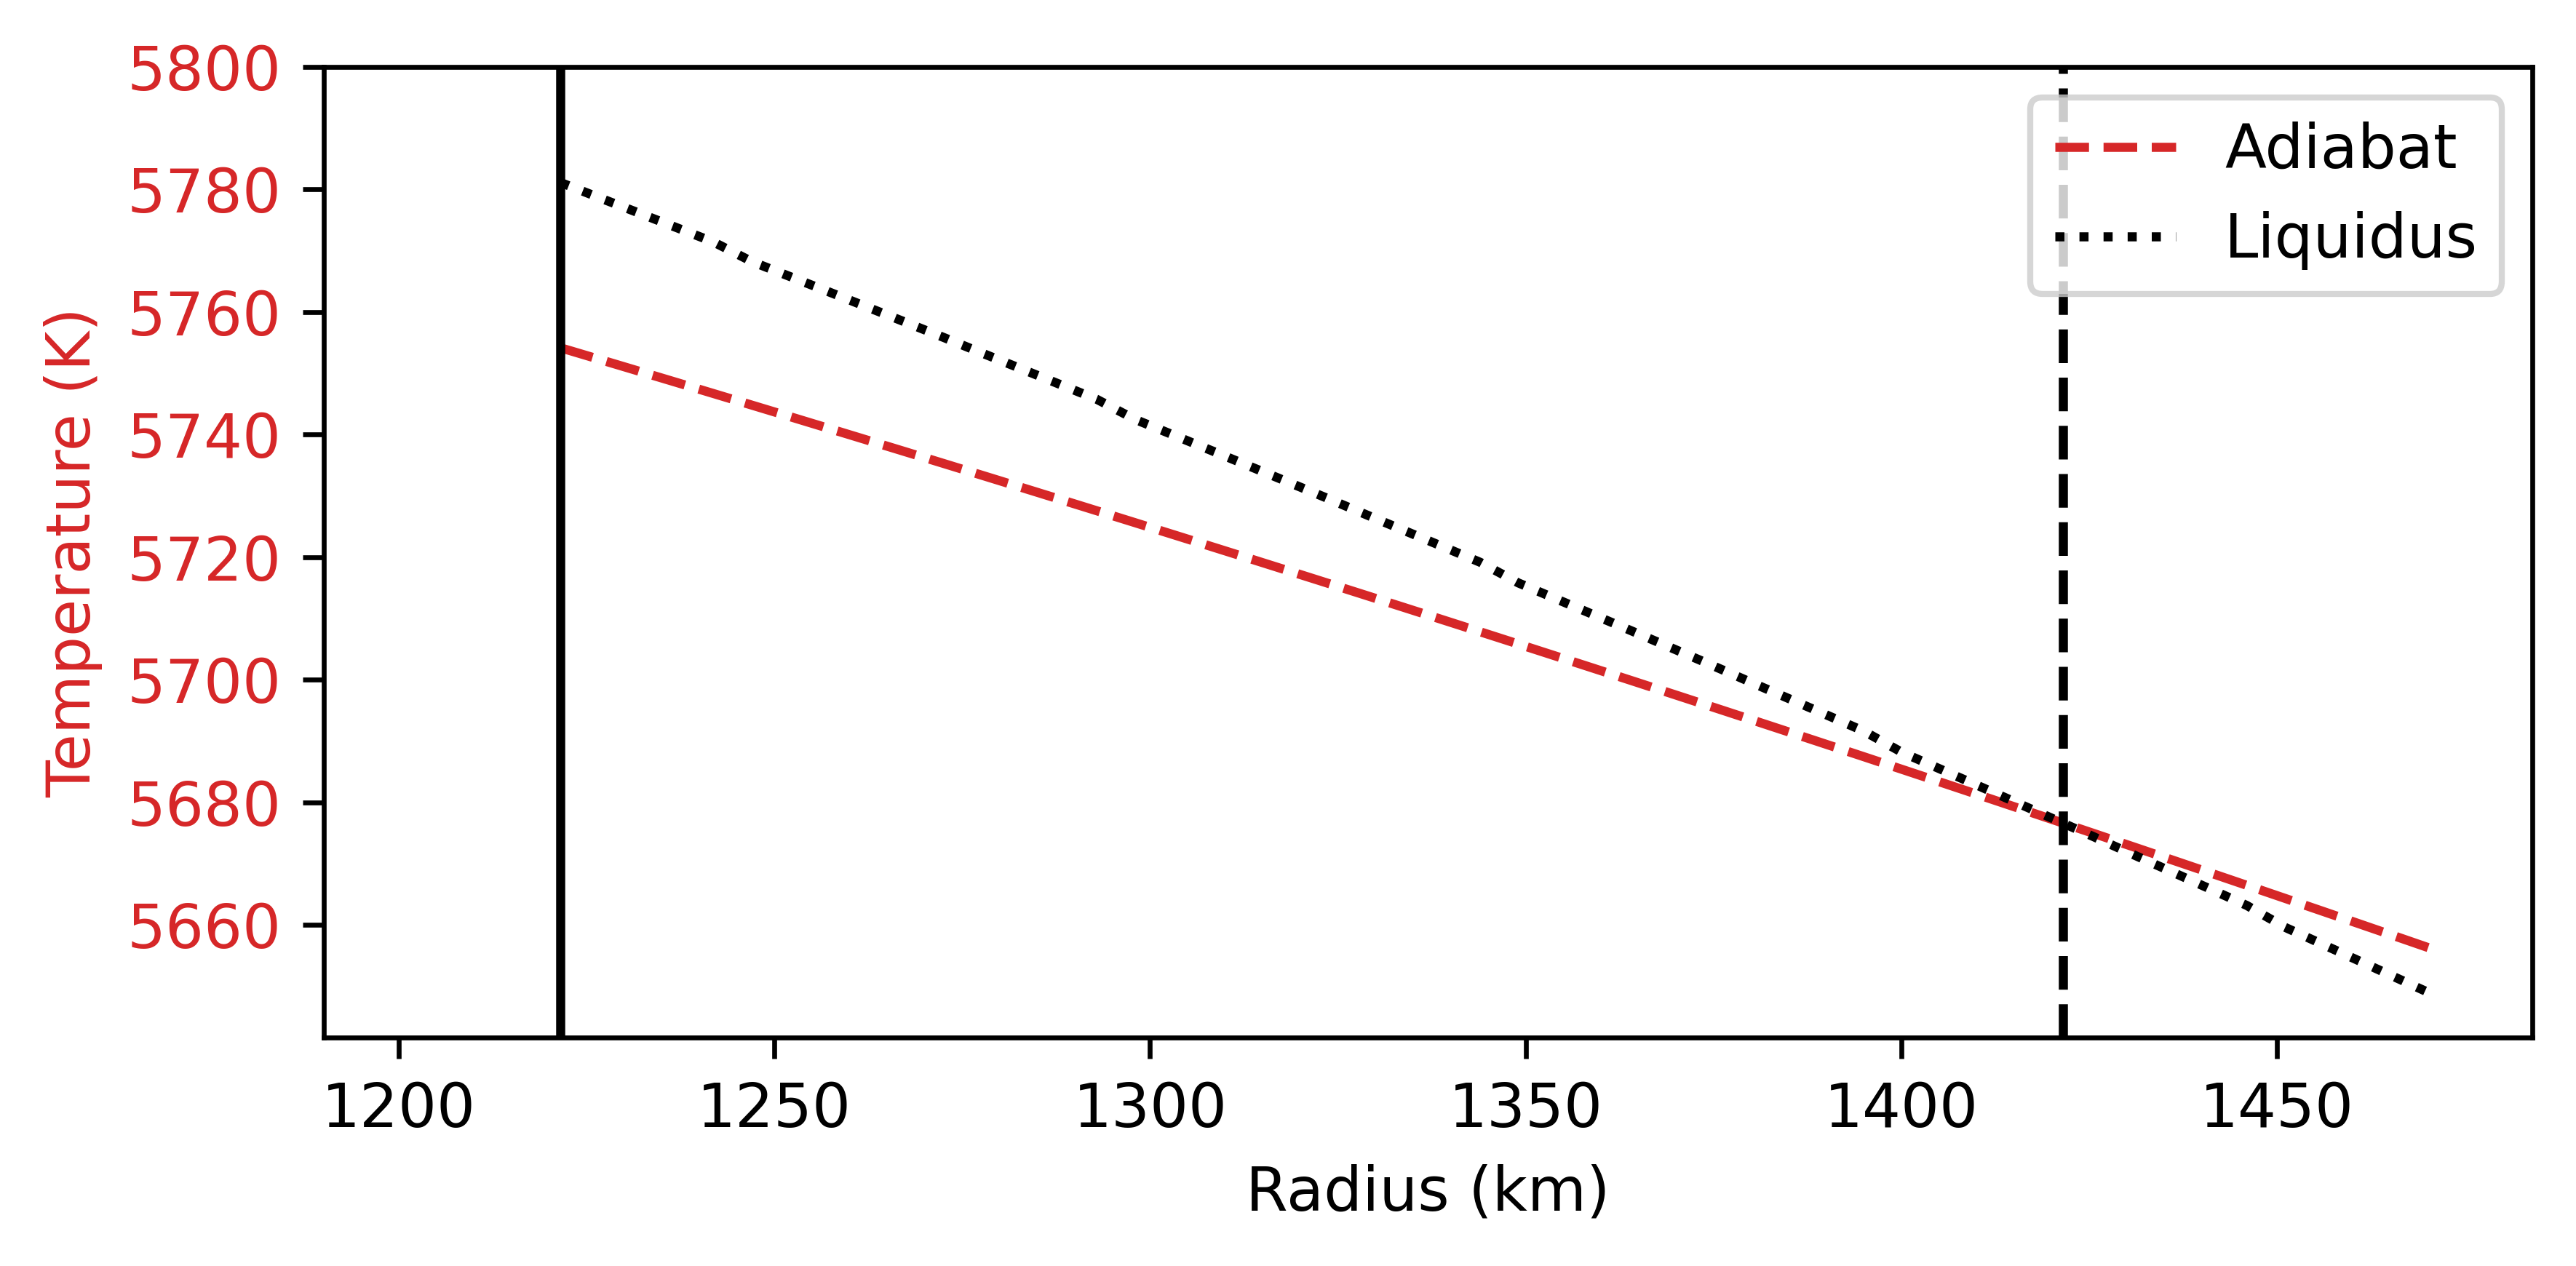

In [5]:
# Plot the F-layer setup alongside the liquidus
fig, ax1 = plt.subplots(figsize=(6,3), tight_layout=True, dpi=600)

color = 'tab:red'
ax1.set_xlabel('Radius (km)')
ax1.set_ylabel('Temperature (K)', color=color)
ax1.plot(rs/1000.0, ats, color=color, ls='--', label='Adiabat')
ax1.plot(rs/1000.0, tl, color='k', ls=':', label='Liquidus')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim(left=1190)
ax1.axvline(x=1221.5, color='k')
ax1.set_ylim(top=5800)
ax1.axvline(x=1421.5, color='k', ls='--')

ax1.legend(loc='upper right')

fig.tight_layout()  
plt.show()
